In [1]:
import torch
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import torch.nn as nn
import torchvision.transforms.functional as TF
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import math
import skimage.io
from torch.utils.data import Dataset

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### functions

In [2]:
def read_and_plot_img(PATH_TO_IMAGE, show=False):
    image = cv2.imread(PATH_TO_IMAGE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if show:
        plt.imshow(image);
    return image 

In [3]:
def detect_faces(image, min_face_size=200):
    img = Image.fromarray(image)

    mtcnn = MTCNN(keep_all=True, device=device, min_face_size=min_face_size)
    boxes, _ = mtcnn.detect(img)
    boxes = np.array(boxes, dtype=np.float32)

    if boxes.shape:
        crop_image_list = []
        for box in boxes:  
            x1 = int(box[1])
            x2 = int(box[3])
            y1 = int(box[0])
            y2 = int(box[2])
            crop_img = image[x1:x2,y1:y2:]
            crop_image_list.append(crop_img)

    return crop_image_list

In [4]:
def get_landmarks(img, model):
    img = TF.to_tensor(img)
    img = TF.resize(img, (224,224))
    img = TF.normalize(img, [0.5], [0.5])
    img = img[None,:,:,:]
    
    model.eval()
    with torch.no_grad():
        inputs = img
        outputs = model(inputs)
        outputs = (outputs + 0.5) * 224
        outputs = outputs.view(-1, 68, 2)
    return outputs[0].numpy()

In [5]:
def find_angle(image, eyePoints):
    leftEyeX,leftEyeY = eyePoints[0]
    rightEyeX, rightEyeY = eyePoints[1]
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    return angle

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [6]:
def get_align_img(img, landmarks):
    eyePoints = (landmarks[39], landmarks[42])
    angle = find_angle(img, eyePoints)
    align_img = rotate_image(img, angle)
    return align_img

In [7]:
def align_face(crop_image_list, model):
    align_img_list = []
    for img in crop_image_list:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        landmarks = get_landmarks(gray_img, model)
        final_align_img = get_align_img(img, landmarks)
        align_img_list.append(final_align_img)
    return align_img_list

In [8]:
def compute_embeddings(model, align_img_list):   
    model.eval()
    embeddings = []
    with torch.no_grad():
        for img in align_img_list:
            img = TF.to_tensor(img)
            img = TF.resize(img, (224,224))
            img = TF.normalize(img, [0.5], [0.5])
            img = img[None,:,:,:]
    
            img = img.to(device)
            outputs = model(img)
            if len(outputs) > 1:
                outputs = outputs[1]
            outputs = outputs.detach().cpu().numpy()
            outputs = [list(i.flatten()) for i in outputs]            
            embeddings.extend(outputs)
       
    return embeddings

### total pipeline

In [9]:
class CustomResNet(nn.Module):
    def __init__(self, model, n_classes):
        super(CustomResNet, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-2])
        
        # Define the new fully connected layers
        self.fc = nn.Sequential(
                    nn.Linear(model.fc.in_features, n_classes),
        )


    def forward(self, x):
        features_before_fc = self.features(x)
        features_before_fc = torch.mean(features_before_fc, dim=[2, 3])
        features_before_fc = features_before_fc.view(features_before_fc.size(0), -1)

        final_output = self.fc(features_before_fc)

        return features_before_fc, final_output

In [10]:
class ModelLandmark(nn.Module):
    def __init__(self, model, n_classes):
        super(ModelLandmark, self).__init__()
        self.model = model
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, n_classes)
        

    def forward(self, x):
        x=self.model(x)
        return x
    
model_align_faces = torch.load('./models/model_alignment.bin', map_location=torch.device('cpu'))

In [11]:
PATH_TO_MODEL = './models/model_ce.bin'

class ModelWithoutLastLayer(nn.Module):
    def __init__(self, model):
        super(ModelWithoutLastLayer, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        return self.features(x)

model_get_embeddings = torch.load(PATH_TO_MODEL, map_location=torch.device('cpu'))
model_get_embeddings = ModelWithoutLastLayer(model_get_embeddings)

In [12]:
def get_faces_embeddingds(PATH_TO_IMAGE, model_align_faces=model_align_faces, model_get_embeddings=model_get_embeddings):
    img = read_and_plot_img(PATH_TO_IMAGE, show=False)
    crop_image_list = detect_faces(img, min_face_size=200)
    align_img_list = align_face(crop_image_list, model_align_faces)
    embeddings = compute_embeddings(model_get_embeddings, align_img_list)
    return embeddings

In [13]:
embeddings_with_many_faces_img = get_faces_embeddingds(PATH_TO_IMAGE = './data/test_img2.jpg', model_align_faces=model_align_faces, model_get_embeddings=model_get_embeddings)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:
len(embeddings_with_many_faces_img), len(embeddings_with_many_faces_img[0]), len(embeddings_with_many_faces_img[1]), len(embeddings_with_many_faces_img[2])

(3, 2048, 2048, 2048)

it's worked!

### test pipeline

In [15]:
def cosine_similarity(v1,v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

##### get embeddings for two similar and two different faces with ce model

let's look at two images:  
- one with two different faces 
- second with one same face as from first image

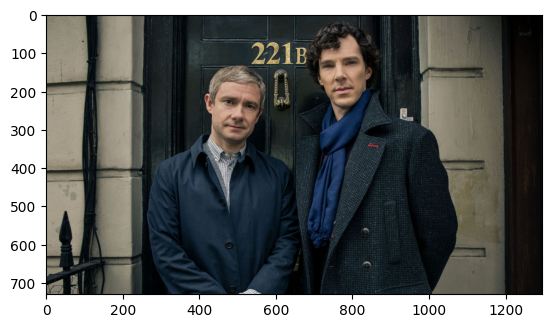

In [16]:
img1 = read_and_plot_img(PATH_TO_IMAGE='./data/test_pipeline1.jpg', show=True)

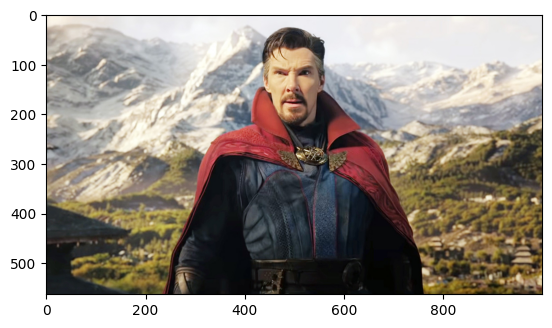

In [17]:
img2 = read_and_plot_img(PATH_TO_IMAGE='./data/test_pipeline2.jpg', show=True)

In [18]:
embeddings_img1 = get_faces_embeddingds(PATH_TO_IMAGE = './data/test_pipeline1.jpg', model_align_faces=model_align_faces, model_get_embeddings=model_get_embeddings)
embeddings_img2 = get_faces_embeddingds(PATH_TO_IMAGE = './data/test_pipeline2.jpg', model_align_faces=model_align_faces, model_get_embeddings=model_get_embeddings)

In [19]:
cs_watson_sherlock = cosine_similarity(embeddings_img1[0], embeddings_img1[1])
cs_watson_strange = cosine_similarity(embeddings_img1[0], embeddings_img2[0])
cs_sherlock_strange = cosine_similarity(embeddings_img1[1], embeddings_img2[0])

In [20]:
cs_watson_sherlock, cs_watson_strange, cs_sherlock_strange

(0.8624134, 0.8338717, 0.8717549)

Sherlock and Dr Strange the most similar with each other, we expect that because this is one actor :)  
Watson and Dr Strange most unsimilar on each other -> different people from differnt universes :)  
Watson and Sherlock similar to each other, probably last model was not working good (small sample for train)

##### get embeddings for two similar and two different faces with arc face model

In [21]:
model_get_embeddings_arc_face = torch.load('./models/model_af.bin', map_location=torch.device('cpu'))

In [22]:
embeddings_img1 = get_faces_embeddingds(PATH_TO_IMAGE = './data/test_pipeline1.jpg', model_align_faces=model_align_faces, model_get_embeddings=model_get_embeddings_arc_face)
embeddings_img2 = get_faces_embeddingds(PATH_TO_IMAGE = './data/test_pipeline2.jpg', model_align_faces=model_align_faces, model_get_embeddings=model_get_embeddings_arc_face)

In [23]:
cs_watson_sherlock = cosine_similarity(embeddings_img1[0], embeddings_img1[1])
cs_watson_strange = cosine_similarity(embeddings_img1[0], embeddings_img2[0])
cs_sherlock_strange = cosine_similarity(embeddings_img1[1], embeddings_img2[0])

In [24]:
cs_watson_sherlock, cs_watson_strange, cs_sherlock_strange

(0.9999598, 0.9996741, 0.9998298)

All people similar with each other, probably there is problems with settings for ArcFace loss.

In general pipelne is working, for 3rd part with embeddings needs more work with more data for training model and also look at different losses for training.